In [320]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LinearRegression, RidgeCV, ElasticNet, Ridge, Lasso
from helper import *
import shap


In [321]:
def one_on_one_plot(var_1: str, var_2: str, df: pd.DataFrame, rate: float = 1.5):
    data_pairplot = pd.concat([df[var_2], df[var_1]], axis=1)
    plt.subplots(figsize=(8, 6))
    fig = sns.boxplot(x=var_1, y=var_2, data=data_pairplot)
    y_min = data_pairplot[var_2].min()
    if y_min == 0: y_min = -1
    fig.axis(ymin= y_min / rate, ymax=rate * data_pairplot[var_2].max())

def encode_ordinal(df: pd.DataFrame, col_name: str, feature_dict=None ):
    if feature_dict is None:
        feature_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, "NA": 0}
    return df[col_name].replace(feature_dict).astype("int64")

def one_hot_encode(df: pd.DataFrame, col_name: str, prefix=None):
    """
    One-hot encode nominal categorical variable.
    """
    return df.join(pd.get_dummies(df[col_name], drop_first=True, prefix=col_name)) if not prefix \
        else  df.join(pd.get_dummies(df[col_name], drop_first=True, prefix=prefix))

In [322]:
# """
# Read the data
# """
# data = pd.read_csv("data/train.csv").drop(["Id"], axis=1)
# data_test = pd.read_csv("data/test.csv")
# data_sub = pd.read_csv("data/submission.csv")
#
# data_extend = pd.concat([data_test, data_sub], axis=1).drop(["Id"], axis=1)
# data  = pd.concat([data, data_extend])
#
# """
# drop unused features
# """
# data = data.drop(["MiscFeature", 'Utilities', 'MiscVal'],axis=1)
# """
# summarize all bathrooms data into one.
# """
# data['BsmtFullBath'] = data['BsmtFullBath'].fillna(0)
# data['BsmtHalfBath'] = data['BsmtHalfBath'].fillna(0)
# data['Bathrooms'] = data["BsmtFullBath"] + 0.5 * data["BsmtHalfBath"] + data["FullBath"] + 0.5 * data["HalfBath"]
#
# data = data.drop(["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"], axis=1)
# data.insert(0, 'Bathrooms', data.pop('Bathrooms'))
#
# data.to_csv("data/data_all.csv")

In [323]:
data = pd.read_csv("data/data_all.csv")
data = data.drop(["Unnamed: 0"], axis=1)

In [324]:
# numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# data_num_cols = data.select_dtypes(include=numerics).drop(['SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'OverallQual'], axis=1).columns
# data_num_cols

In [325]:
data['GarageCars'] = data['GarageCars'].fillna(0)
data['GarageArea'] = data['GarageArea'].fillna(0)


In [326]:
data = data[data['Exterior1st'].notna()]
data = data[data['Exterior2nd'].notna()]

for col in data.columns:
    print(col,data[col].isna().sum())

Bathrooms 0
MSSubClass 0
MSZoning 4
LotFrontage 486
LotArea 0
Street 0
Alley 2720
LotShape 0
LandContour 0
LotConfig 0
LandSlope 0
Neighborhood 0
Condition1 0
Condition2 0
BldgType 0
HouseStyle 0
OverallQual 0
OverallCond 0
YearBuilt 0
YearRemodAdd 0
RoofStyle 0
RoofMatl 0
Exterior1st 0
Exterior2nd 0
MasVnrType 24
MasVnrArea 23
ExterQual 0
ExterCond 0
Foundation 0
BsmtQual 81
BsmtCond 82
BsmtExposure 82
BsmtFinType1 79
BsmtFinSF1 1
BsmtFinType2 80
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
Heating 0
HeatingQC 0
CentralAir 0
Electrical 1
1stFlrSF 0
2ndFlrSF 0
LowQualFinSF 0
GrLivArea 0
BedroomAbvGr 0
KitchenAbvGr 0
KitchenQual 1
TotRmsAbvGrd 0
Functional 2
Fireplaces 0
FireplaceQu 1420
GarageType 156
GarageYrBlt 158
GarageFinish 158
GarageCars 0
GarageArea 0
GarageQual 158
GarageCond 158
PavedDrive 0
WoodDeckSF 0
OpenPorchSF 0
EnclosedPorch 0
3SsnPorch 0
ScreenPorch 0
PoolArea 0
PoolQC 2908
Fence 2347
MoSold 0
YrSold 0
SaleType 1
SaleCondition 0
SalePrice 0


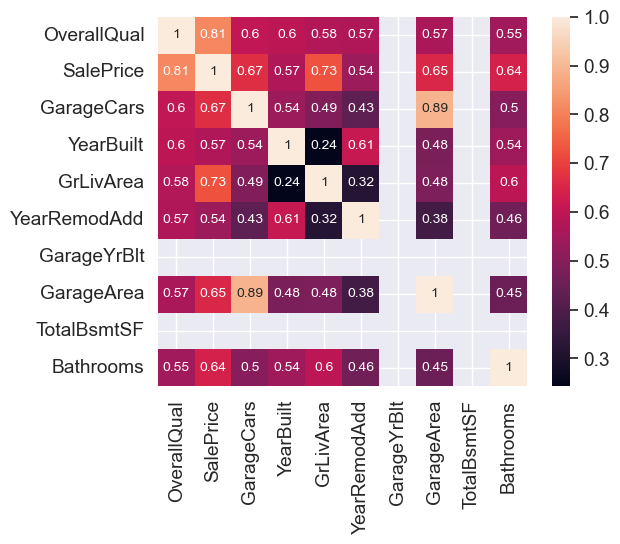

In [327]:
corrmat = data.corr(numeric_only=True)
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'OverallQual')['OverallQual'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()


In [328]:
'''
Explore LotFrontage, fill NaN column with Avg from each neighborhood.
'''
print(data["LotFrontage"].isna().sum())
neighborhoods = set(data['Neighborhood'])
mean_LF_per_neighborhood = {}
for neighborhood in neighborhoods:
    mean_LF_per_neighborhood[neighborhood] = data.loc[data['Neighborhood'] == neighborhood, 'LotFrontage'].mean()
data['LotFrontage'] = data['LotFrontage'].fillna(data['Neighborhood'].map(mean_LF_per_neighborhood))


486


In [329]:
data['GarageFinish'].value_counts()

Unf    1230
RFn     811
Fin     719
Name: GarageFinish, dtype: int64

### Explore Garage:
- FillNa of GarageYrBlt with value from YearBuilt.
- FillNa of other with 'NA' (str), except GarageType
- GarageType: One-hot encode.
- Other garage features (ordinal): ordinal encode.

In [330]:
data_garage = [ "GarageCond", "GarageType", "GarageYrBlt", "GarageFinish", "GarageCars" , "GarageQual", "GarageArea", "GarageCars"]

data['GarageYrBlt'] = data['GarageYrBlt'].fillna(data["YearBuilt"])

for col in data_garage:
    print(col, data[col].isna().sum())

data['GarageCond'] = data['GarageCond'].fillna('TA')
data['GarageCond'] = encode_ordinal(data, 'GarageCond')

GarageFinish_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1}
GarageQual_dict = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}

data['GarageFinish'] = data['GarageFinish'].fillna('Unf')
data['GarageFinish'] = encode_ordinal(data, 'GarageFinish', GarageFinish_dict)

data['GarageQual'] = data['GarageQual'].fillna('TA')
data['GarageQual'] = encode_ordinal(data, 'GarageQual')

data = one_hot_encode(data, 'GarageType')
data = data.drop(['GarageType'], axis=1)


GarageCond 158
GarageType 156
GarageYrBlt 0
GarageFinish 158
GarageCars 0
GarageQual 158
GarageArea 0
GarageCars 0


### Basement features:
- Temporary drop some basement for now, only keep Qual and Cond

In [331]:
data['BsmtQual'] = data['BsmtQual'].fillna('TA')
data['BsmtCond'] = data['BsmtCond'].fillna('TA')

data['BsmtQual'] = encode_ordinal(data, 'BsmtQual')
data['BsmtCond'] = encode_ordinal(data, 'BsmtCond')

data['UnfBsmtRat'] = data['BsmtUnfSF'] / data['TotalBsmtSF']

data['UnfBsmtRat'] = data['UnfBsmtRat'].fillna(data['UnfBsmtRat'].mean())
data = data.drop(['BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF'], axis=1)

### Masonry veneer features:
- Type: FillNa with NA.
- Area: FillNa with 0

In [332]:
data['MasVnrType'] = data['MasVnrType'].fillna('None')
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)

data = one_hot_encode(data, 'MasVnrType')
data = data.drop(['MasVnrType', 'MasVnrType_None'], axis=1)


### Zoning data:
- MSZoning: Onehot
- MsSubClass: Change to object + onehot
- Update: drop?

In [333]:
# data = one_hot_encode(data, 'MSZoning')
data = data.drop(['MSZoning'], axis=1)
# data['MSSubClass'] = data['MSSubClass'].astype(object)
# data['MSSubClass'].value_counts()
#
# data = one_hot_encode(data, 'MSSubClass')
data = data.drop(['MSSubClass'], axis=1)

### Functional, Kitchen:
- Ordinal encoding.

In [334]:
Functional_dict = {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ":7}

data = data[data['Functional'].notna()]
data = data[data['KitchenQual'].notna()]
data['Functional'] = encode_ordinal(data, 'Functional', feature_dict=Functional_dict)
data['KitchenQual'] = encode_ordinal(data, 'KitchenQual')


### Exterior feature:

- Material: One-hot encode both Exterior 1st and Exterior 2nd together.
- Qual and cond: Ordinal Encoding.

In [335]:



data.loc[data['Exterior1st'] == data['Exterior2nd'],  'Exterior2nd'] = None
data['Exterior2nd'] = data['Exterior2nd'].replace({'Brk Cmn': 'BrkComm', 'Wd Shng': 'WdShing' }).astype("str")

data = data.join(
pd.get_dummies(data.filter(like='Exterior').stack(), prefix='Exterior')
  .groupby(level=0).max())


data = data.drop(['Exterior1st', 'Exterior2nd', 'Exterior_None', 'Exterior_Other'], axis=1)
data['ExterQual'] = encode_ordinal(data, 'ExterQual')
data['ExterCond'] = encode_ordinal(data, 'ExterCond')




### Electrical:
- Fill Na with the most common (SBrKr)
- Change mix to FuseA (average)
- Ordinal encoding.

In [336]:
data['Electrical'] = data['Electrical'].fillna('SBrkr')
Electrical_dict = {'SBrkr' : 3, 'FuseA': 2, 'FuseF': 1, 'FuseP' : 0, 'Mix': 2}
print(data['Electrical'].value_counts())
data['Electrical'] = encode_ordinal(data, 'Electrical', feature_dict=Electrical_dict)

SBrkr    2669
FuseA     187
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64


### SaleType and SaleCondition:
- Drop for now.

In [337]:
data = data.drop(['SaleType', 'SaleCondition'], axis=1)

### Heating:
- Type: drop
- Quality: Ordinal
- CentralAir: Encode 0-1


In [338]:
data['CentralAir'] = data["CentralAir"].replace({'Y': 1, 'N' : 0}).astype("int64")

print(data[["CentralAir"]].value_counts())
print(data[["Heating"]].value_counts())
print(data[["HeatingQC"]].value_counts())

print(data[["CentralAir"]].isna().sum())
print(data[["Heating"]].isna().sum())
print(data[["HeatingQC"]].isna().sum())

data['HeatingQC'] = encode_ordinal(data, 'HeatingQC')
data = data.drop(['Heating'], axis=1)

CentralAir
1             2721
0              194
dtype: int64
Heating
GasA       2871
GasW         27
Grav          9
Wall          5
OthW          2
Floor         1
dtype: int64
HeatingQC
Ex           1492
TA            857
Gd            473
Fa             91
Po              2
dtype: int64
CentralAir    0
dtype: int64
Heating    0
dtype: int64
HeatingQC    0
dtype: int64


### Roof:
- Style and mat: One-hot Encoding

In [339]:
print(data['RoofStyle'].value_counts())
print(data[["RoofStyle"]].isna().sum())
print(data['RoofMatl'].value_counts())
print(data[["RoofMatl"]].isna().sum())

data = one_hot_encode(data, 'RoofStyle')
data = data.drop(['RoofStyle'], axis=1)

data = one_hot_encode(data, 'RoofMatl')
data = data.drop(['RoofMatl'], axis=1)

Gable      2307
Hip         551
Gambrel      22
Flat         19
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64
RoofStyle    0
dtype: int64
CompShg    2873
Tar&Grv      22
WdShake       9
WdShngl       7
Metal         1
Membran       1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64
RoofMatl    0
dtype: int64


### Land:
- Slope: Ordinal encoding
- Contour: one-hot.

In [340]:
print(data['LandContour'].value_counts())
print(data[["LandContour"]].isna().sum())

data = one_hot_encode(data, 'LandContour')
data = data.drop(['LandContour'], axis=1)

print(data['LandSlope'].value_counts())
print(data[["LandSlope"]].isna().sum())


LandSlope_dict = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
data['LandSlope'] = encode_ordinal(data, 'LandSlope', feature_dict=LandSlope_dict)


Lvl    2619
HLS     120
Bnk     117
Low      59
Name: LandContour, dtype: int64
LandContour    0
dtype: int64
Gtl    2775
Mod     124
Sev      16
Name: LandSlope, dtype: int64
LandSlope    0
dtype: int64


### Foundation:
- One-hot encoding

In [341]:
print(data['Foundation'].value_counts())
print(data[["Foundation"]].isna().sum())
data = one_hot_encode(data, 'Foundation')
data = data.drop(['Foundation'], axis=1)

PConc     1307
CBlock    1234
BrkTil     310
Slab        48
Stone       11
Wood         5
Name: Foundation, dtype: int64
Foundation    0
dtype: int64


### Dwelling:
- Drop for now (BldgType and houseStyle)

In [342]:
data = data.drop(['BldgType', 'HouseStyle'], axis=1)

### Paved Street and Paved Driveway:
- Onehot Encoded.

In [343]:
data["Street"] = data["Street"].replace({'Pave': 1, 'Grvl' : 0}).astype("int64")
data["PavedDrive"] = data["PavedDrive"].replace({'Y': 2, 'P': 1, 'N' : 0}).astype("int64")


### Neigborhood-related:
- Neighborhood: remove? Because how is neighborhood affect house quality? Will see later.
- Condition 1 and 2: dropped

In [344]:
# data = one_hot_encode(data, 'Neighborhood')
data = data.drop(['Condition1', 'Condition2', 'Neighborhood'], axis=1)

### Fireplaces

In [345]:
data['FireplaceQu'] = data['FireplaceQu'].fillna("NA")
data_cat_ordinal = data[["FireplaceQu"]].columns

FireplaceQu_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, "NA": 3}
data['FireplaceQu'] = encode_ordinal(data, 'FireplaceQu', FireplaceQu_dict)


### Alley:
- Too many missing -> drop

In [346]:
data = data.drop(['Alley'], axis=1)

### Porch-area related features:
- Drop for now

In [347]:
data = data.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis=1)

### Total area of the house

In [348]:
# data['TotalSqFt'] = data['GrLivArea'] + data['TotalBsmtSF']
data['UnfSqFtRatio'] = data['LowQualFinSF'] / data['GrLivArea']
data = data.drop(['GrLivArea', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'LotArea', 'LotFrontage'], axis=1)

### Year and age:
- Age: Year sold - renovated.
- IsNew: If sold right after built
- IsRennovated: If the house is rennovated or not.

In [349]:
data['Age'] =  data['YrSold'] - data['YearRemodAdd']
data['IsNew'] =  data['YrSold'] == data['YearBuilt']
data['Renovated'] = data['YearRemodAdd'] != data['YearBuilt']
data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']

data = data.drop(['MoSold', 'YrSold', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd'], axis=1)

data[['Renovated', 'IsNew']] = data[['Renovated', 'IsNew']].astype(int)

### Pool
- Drop Area, keep quality.

In [350]:
data["PoolQC"] = data["PoolQC"].fillna("NA")
PoolQC_dict = {'Ex': 1, 'Gd': 1, 'TA': 1, 'Fa': 1, 'Po': 1, "NA": 0}
data['HasPool'] = encode_ordinal(data, 'PoolQC', PoolQC_dict)
data = data.drop(['PoolArea', 'PoolQC'], axis=1)

In [351]:
corrmat = data.corr(numeric_only=True)
k = 15 #number of variables for heatmap

print(corrmat.nlargest(k, 'OverallQual')['OverallQual'])
print(corrmat.nsmallest(5, 'OverallQual')['OverallQual'])


OverallQual         1.000000
SalePrice           0.811829
ExterQual           0.732425
BsmtQual            0.679258
KitchenQual         0.675435
GarageCars          0.602199
Foundation_PConc    0.567542
GarageArea          0.566158
Bathrooms           0.546512
GarageFinish        0.535696
HeatingQC           0.472012
MasVnrArea          0.426534
Fireplaces          0.391060
TotRmsAbvGrd        0.388686
FireplaceQu         0.375920
Name: OverallQual, dtype: float64
GarageAge           -0.576987
Age                 -0.572428
Foundation_CBlock   -0.410104
GarageType_Detchd   -0.342349
RoofStyle_Gable     -0.189011
Name: OverallQual, dtype: float64


### Fence:
- Drop for now.

In [352]:
data = data.drop(['Fence', 'LotShape', 'LotConfig', 'TotRmsAbvGrd'], axis=1)


### Taking log of some SalePrice variable.

In [353]:
data['SalePrice'] = np.log(data['SalePrice'])

In [354]:
data['OverallCond'].value_counts()

5    1644
6     531
7     389
8     144
4     101
3      49
9      41
2      10
1       6
Name: OverallCond, dtype: int64

In [355]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_num_cols = data.select_dtypes(include=numerics).drop(['SalePrice', 'OverallQual', 'OverallCond'], axis=1).columns

In [356]:
data[data_num_cols] = 1 + (data[data_num_cols] - data[data_num_cols].min()) * 9 / (data[data_num_cols].max() - data[data_num_cols].min())
data

,Bathrooms,Street,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,UnfSqFtRatio,Age,IsNew,Renovated,GarageAge,HasPool
0,4.75,10.0,10.0,7,5,2.10250,7.0,5.5,7.0,7.0,...,1,0,0,0,1.0,2.016129,1.0,1.0,6.491071,1.0
1,3.25,10.0,10.0,6,8,1.00000,4.0,5.5,7.0,7.0,...,0,0,0,0,1.0,5.790323,1.0,1.0,7.187500,1.0
2,4.75,10.0,10.0,7,5,1.91125,7.0,5.5,7.0,7.0,...,1,0,0,0,1.0,2.161290,1.0,10.0,6.544643,1.0
3,2.50,10.0,10.0,7,5,1.00000,4.0,5.5,4.0,10.0,...,0,0,0,0,1.0,6.516129,1.0,10.0,6.571429,1.0
4,4.75,10.0,10.0,8,5,2.96875,7.0,5.5,7.0,7.0,...,1,0,0,0,1.0,2.451613,1.0,1.0,6.571429,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1.75,10.0,10.0,4,7,1.00000,4.0,5.5,4.0,7.0,...,0,0,0,0,1.0,6.516129,1.0,1.0,7.321429,1.0
2915,1.75,10.0,10.0,4,5,1.00000,4.0,5.5,4.0,7.0,...,0,0,0,0,1.0,6.516129,1.0,1.0,7.321429,1.0
2916,2.50,10.0,10.0,5,7,1.00000,4.0,5.5,4.0,7.0,...,0,0,0,0,1.0,2.741935,1.0,10.0,7.589286,1.0
2917,1.75,10.0,10.0,5,5,1.00000,4.0,5.5,7.0,7.0,...,1,0,0,0,1.0,3.322581,1.0,1.0,6.732143,1.0


In [357]:
data = data.reset_index(drop=True)
data.to_csv('data/data_cleaned.csv')